# <center> Deep Learning Project:

## Group Members
> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 

- The objective of this project is to forecast the evolutions of "bitcoin" prices, by using reccurent neural networks.
such as RNN and LSTM.
- The project is organized as follows:

In [1]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner

In [2]:
import time
t1 = time.perf_counter()

- __Importing the necessary libraries 📚:__

In [3]:
import os
from zipfile import ZipFile
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt

In [4]:
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, LSTM, Embedding, Input, Dropout, SimpleRNN, RNN, Bidirectional
#from keras.Optimizer import Adam, SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl, schedules
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, History, ReduceLROnPlateau 
#from keras.utils import plot_model
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor 
import keras.backend as K

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import class_weight

from pprint import pprint

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import category_encoders as ce
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import ClassificationReport

from imblearn.over_sampling import SMOTE

from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve

from sklearn.ensemble import RandomForestClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
SEED = 2022

LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 10
time_steps=5
FIGSIZE = (30,30)

Fixing the random number seed to ensure our results are reproducible.

In [8]:
session = K.get_session()
# init_op = tf.group(tf.tables_initializer(),tf.global_variables_initializer(),
# tf.local_variables_initializer())
#session.run(init_op)

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

- __Helper functions:__

In [9]:
# Function to create dataframe with metricsn

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='weighted'),
                metricsObj.f1_score(yTrain, yPredTrain, average='weighted'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='weighted'),
               metricsObj.f1_score(yTest, yPredTest, average='weighted'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
    return(resultsDF)

In [10]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [11]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [12]:
def create_model(nl=1, nn=256):
    model = Sequential()
    model.add(Dense(16, input_shape=(2,), activation="relu"))
    # Add as many hidden layers as specified in nl
    for _ in range(nl):
        # Layers have nn neurons
        model.add(Dense(nn, activation='relu'))
    # End defining and compiling your model...

In [13]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    plt.show()

In [14]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.tight_layout()
    plt.show()


In [15]:
# This function plot the "loss" and the "val_loss" variables.
def visualize_loss(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
# This function plot the "accuracy" and the "val_accuracy" variables.
def visualize_accuracy(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
# This function plot the "error" and the "val_error" variables.
def visualize_error(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    error = history.history["mae"]
    val_error = history.history["val_mae"]
    epochs = range(len(error))
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, error, "b", label="Training error")
    plt.plot(epochs, val_error, "r", label="Validation error")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def show_plot(plot_data, delta, title):
    """
    plot_data:
    delta:
    title:
    """
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.tight_layout()
    plt.show()
    return

In [19]:
def plot_predictions(val, predicted, title, date):
    plt.figure(figsize=(16,4))
    plt.plot(date, val, color='blue',label='Actual') # date, 
    plt.plot(date,predicted, alpha=0.7, color='red',label='Predict') # date, 
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Something')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
def numerical_corr(ds, figsize=FIGSIZE):
    corr = ds.corr()
    # Generate a lower triangle matrix, where the lower and diagnoal are true, but upper is false
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)]= True

    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr,
        mask = mask,
        square = True,
        linewidths = .5,
        cmap = 'coolwarm',
        vmin = -1,
        vmax = 1,
        annot = True,
        annot_kws = {'size': 10})

    # Add the column names to labels
    ax.set_yticklabels(corr.columns, rotation = 0)
    ax.set_xticklabels(corr.columns, rotation = 0)
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


## Loading the dataset

In [21]:
ds= pd.read_csv("bankruptcy.csv")

In [22]:
ds.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [23]:
ds.shape

(6819, 96)

## Data Preprocessing

### Data Type
All the columns are numeric. There are 2 binary flags that are already enocoded as 0 or 1.
- 85: Liability-Assets Flag
- 94: Net Income Flag

In [24]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

### Check For Duplicates

In [25]:
ds.duplicated().sum()

0

### Correlation

In [26]:
corr = ds.corr()
i = 1
for (index, row) in corr.iterrows():
    for col in corr.columns[i:]:
        if row[col] > 0.9:
            print(f"{index} vs. {col} are highly correlated {row[col]}")
    i += 1

 ROA(C) before interest and depreciation before interest vs.  ROA(A) before interest and % after tax are highly correlated 0.9401237079700807
 ROA(C) before interest and depreciation before interest vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9868494970182541
 ROA(A) before interest and % after tax vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9557406252835042
 ROA(A) before interest and % after tax vs.  Net Income to Total Assets are highly correlated 0.9615519166312979
 ROA(B) before interest and depreciation after tax vs.  Net Income to Total Assets are highly correlated 0.9120401733352151
 Operating Gross Margin vs.  Realized Sales Gross Margin are highly correlated 0.9995182781255221
 Operating Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9999999924887606
 Realized Sales Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9995182260040115
 Operating Profit Rate vs.  Pre-tax net Inter

In [27]:
# Select upper triangle of correlation matrix
corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.9
correlated_cols = [c for c in corr_matrix.columns if any(corr_matrix[c] > 0.9)]
# Drop correlated columns
ds = ds.drop(correlated_cols, axis=1)

In [28]:
#removeOutliers(X, colList=cols , lowPercentile=0.05, highPercentile=0.95, verbose=True) 

In [29]:
# This variable is to be dropped.
X = ds.drop(columns=["Bankrupt?"])
y = ds["Bankrupt?"]
y.unique()

array([1, 0])

## Feature Selection

 Current Asset Turnover Rate              0.0
 Research and development expense rate    0.0
 Current Assets/Total Assets              0.0
 Net Worth Turnover Rate (times)          0.0
 Inventory Turnover Rate (times)          0.0
 Accounts Receivable Turnover             0.0
 Operating Expense Rate                   0.0
 Contingent liabilities/Net worth         0.0
 Interest-bearing debt interest rate      0.0
 Revenue Per Share (Yuan ¥)               0.0
dtype: float64

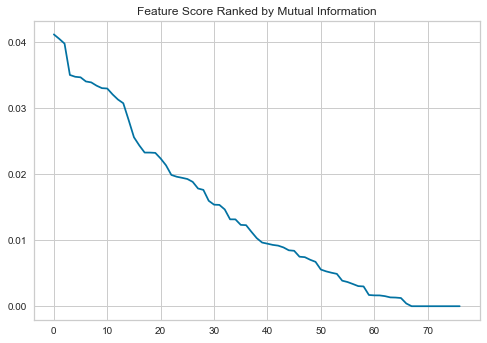

In [30]:
def mutual_info_score(x, y):
    fs = SelectKBest(score_func=mutual_info_classif, k='all').fit(x, y)
    fs_scores = pd.Series(data=fs.scores_, index=fs.feature_names_in_).sort_values(ascending=False)
    fs_scores.plot(use_index=False, title="Feature Score Ranked by Mutual Information")
    return fs_scores

fs_scores = mutual_info_score(X, y)
fs_scores.tail(10)

In [31]:
zero_score_cols = fs_scores.loc[fs_scores == 0].index
X = X.drop(columns=zero_score_cols)

In [32]:
X.shape

(6819, 67)

In [33]:
# Initialize model
rf_model = RandomForestClassifier(n_estimators=10, random_state=SEED)

KeyboardInterrupt: 

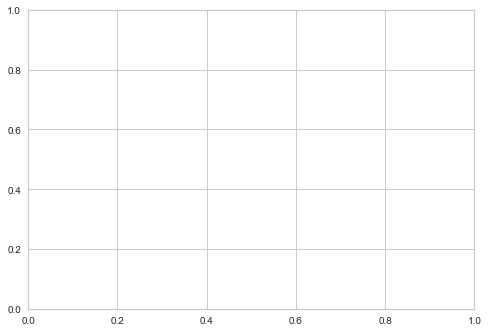

In [34]:
%%timeit

# I get to select 17 features.

# Applying RFECV (Recursive Feature Elimination) to select features
# see https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html
cv = StratifiedKFold(3)
vis = RFECV(rf_model, scoring='f1_weighted') ## , cv=cv
vis.fit(X, y)
vis.show()

In [ ]:
vis.ranking_

In [ ]:
# Features to include: 
ds.columns[vis.support_]

In [ ]:
ds

In [ ]:
# Plot the learning curve

# I DONT NEED LEARNING CURVE NOW, THIS SHOULD BE DONE ON THE NEXT PARTS.

#cv = 3
#sizes = np.linspace(0.1, 1.0, 5)
#visualizer = LearningCurve(estimator=rf_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, random_state=SEED)
#visualizer.fit(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])
#visualizer.show()     

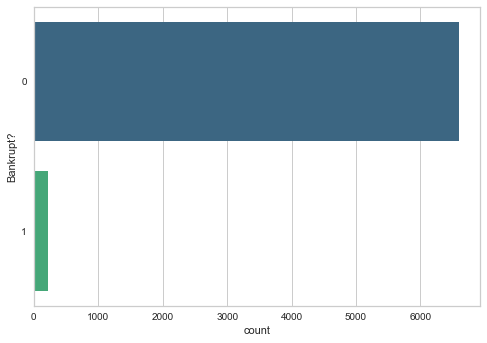

In [35]:
# Checking that the target distribution is imbalanced.

sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h')

In [36]:
# Setting the first line to be the columns name.

ds.columns = ds.iloc[0]
ds = ds.drop(labels=0, axis=0)

# Data Exploration:

In [37]:
# We can see that our dataset does not contain any duplicates.

ds.duplicated().sum()

0

# Data Pre-processing:

## Dealing with outliers:

## One Hot encoding the categorical features:

## Splitting the dataset

In [47]:
# Split the dataset intro train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                   shuffle =True, stratify=y, random_state=SEED)

In [50]:
k = 5
kfold = StratifiedKFold(n_splits=k)
X_kfold_train, X_kfold_val, y_kfold_train, y_kfold_val = [], [], [], []
for train_index, val_index in kfold.split(X_train, y_train):
    X_kfold_train.append(X_train.iloc[train_index])
    X_kfold_val.append(X_train.iloc[val_index])
    # Need to use y directly because y_train is Series
    y_kfold_train.append(y_train.iloc[train_index])
    y_kfold_val.append(y_train.iloc[val_index])

## Data Normalization:

In [51]:
# We use the standard scaler in order to normalize the data

sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

## Modelling:

### Simple Model

In [53]:
def create_model(optim="adam", init="glorot_uniform", loss = "binary_crossentropy"):
    classifier = Sequential()
    classifier.add(Dense(units=128, kernel_initializer=init, activation="relu"))
    classifier.add(Dense(units=64, kernel_initializer=init, activation="relu"))
    classifier.add(Dense(units=32, kernel_initializer=init, activation="sigmoid"))
    
    # Last layer should always have 1 neuron with sigmoid activation function
    classifier.add(Dense(units=1, kernel_initializer=init, activation="sigmoid"))
    classifier.compile(optimizer=optim, loss=loss, metrics=['binary_accuracy'])
    return classifier

In [54]:
def kfold_val(model, epochs, batch_size, class_weight=None, k=k, verbose=0):
    histories = []
    for i in range(k):
        hist = model.fit(X_kfold_train[i],
                        y_kfold_train[i],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_kfold_val[i], y_kfold_val[i]),
                        class_weight=class_weight,
                        verbose=verbose)
        hist_df = pd.DataFrame(hist.history)
        histories.append(hist_df)
        _, ax = plt.subplots(1, 2, figsize=(30,20))
        hist_df[['binary_accuracy', 'val_binary_accuracy']].plot(title=f'K={i} Accuracy', ax=ax[0])
        hist_df[['loss', 'val_loss']].plot(title=f'K={i} Loss', ax=ax[1])
        plt.show()
    avg_val_acc = np.mean([h.iloc[-1]['val_binary_accuracy'] for h in histories])
    print(f"Average validation accuracy is {avg_val_acc}")
        
    return histories

def model_perf(model):
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    cm = confusion_matrix(y_test, y_pred)
    target_names = ['Stay', 'Leave']
    print(classification_report(y_test, y_pred, target_names=target_names))
    plt.figure()
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', yticklabels=target_names, xticklabels=['Predicted_Stay', 'Predicted_Leave'])

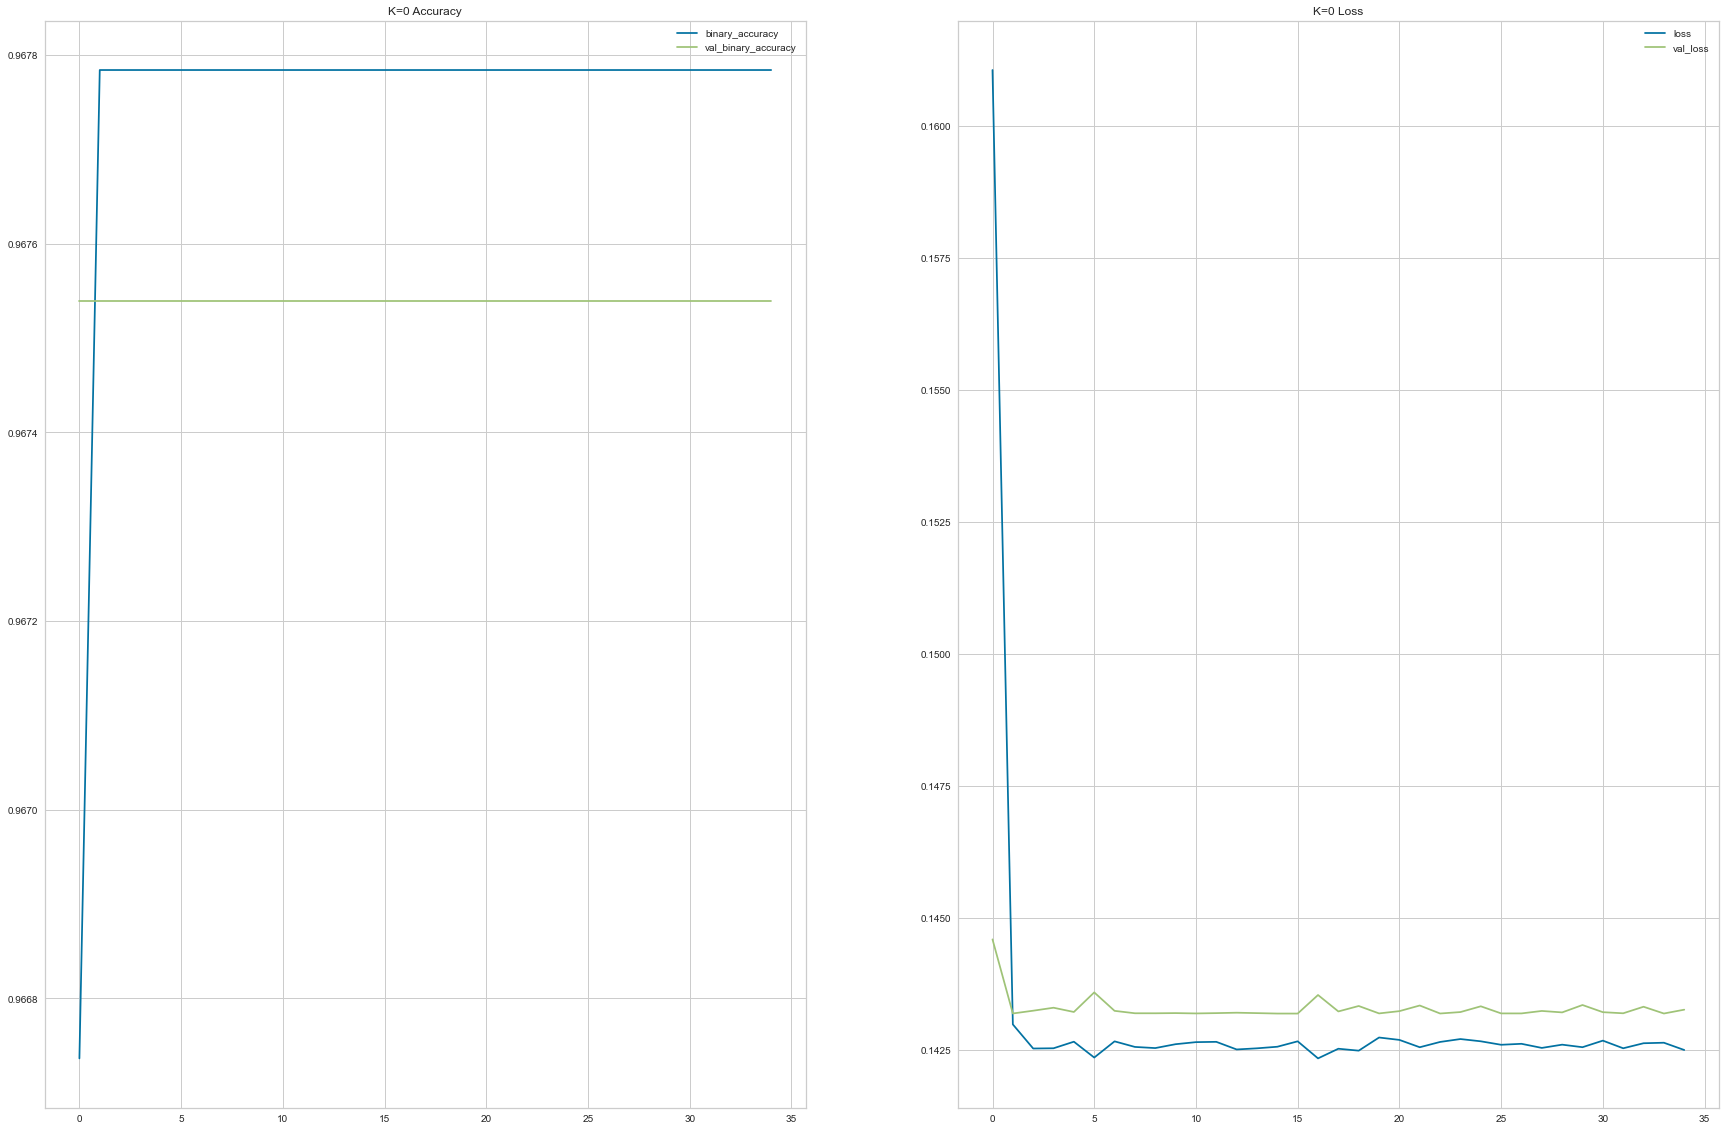

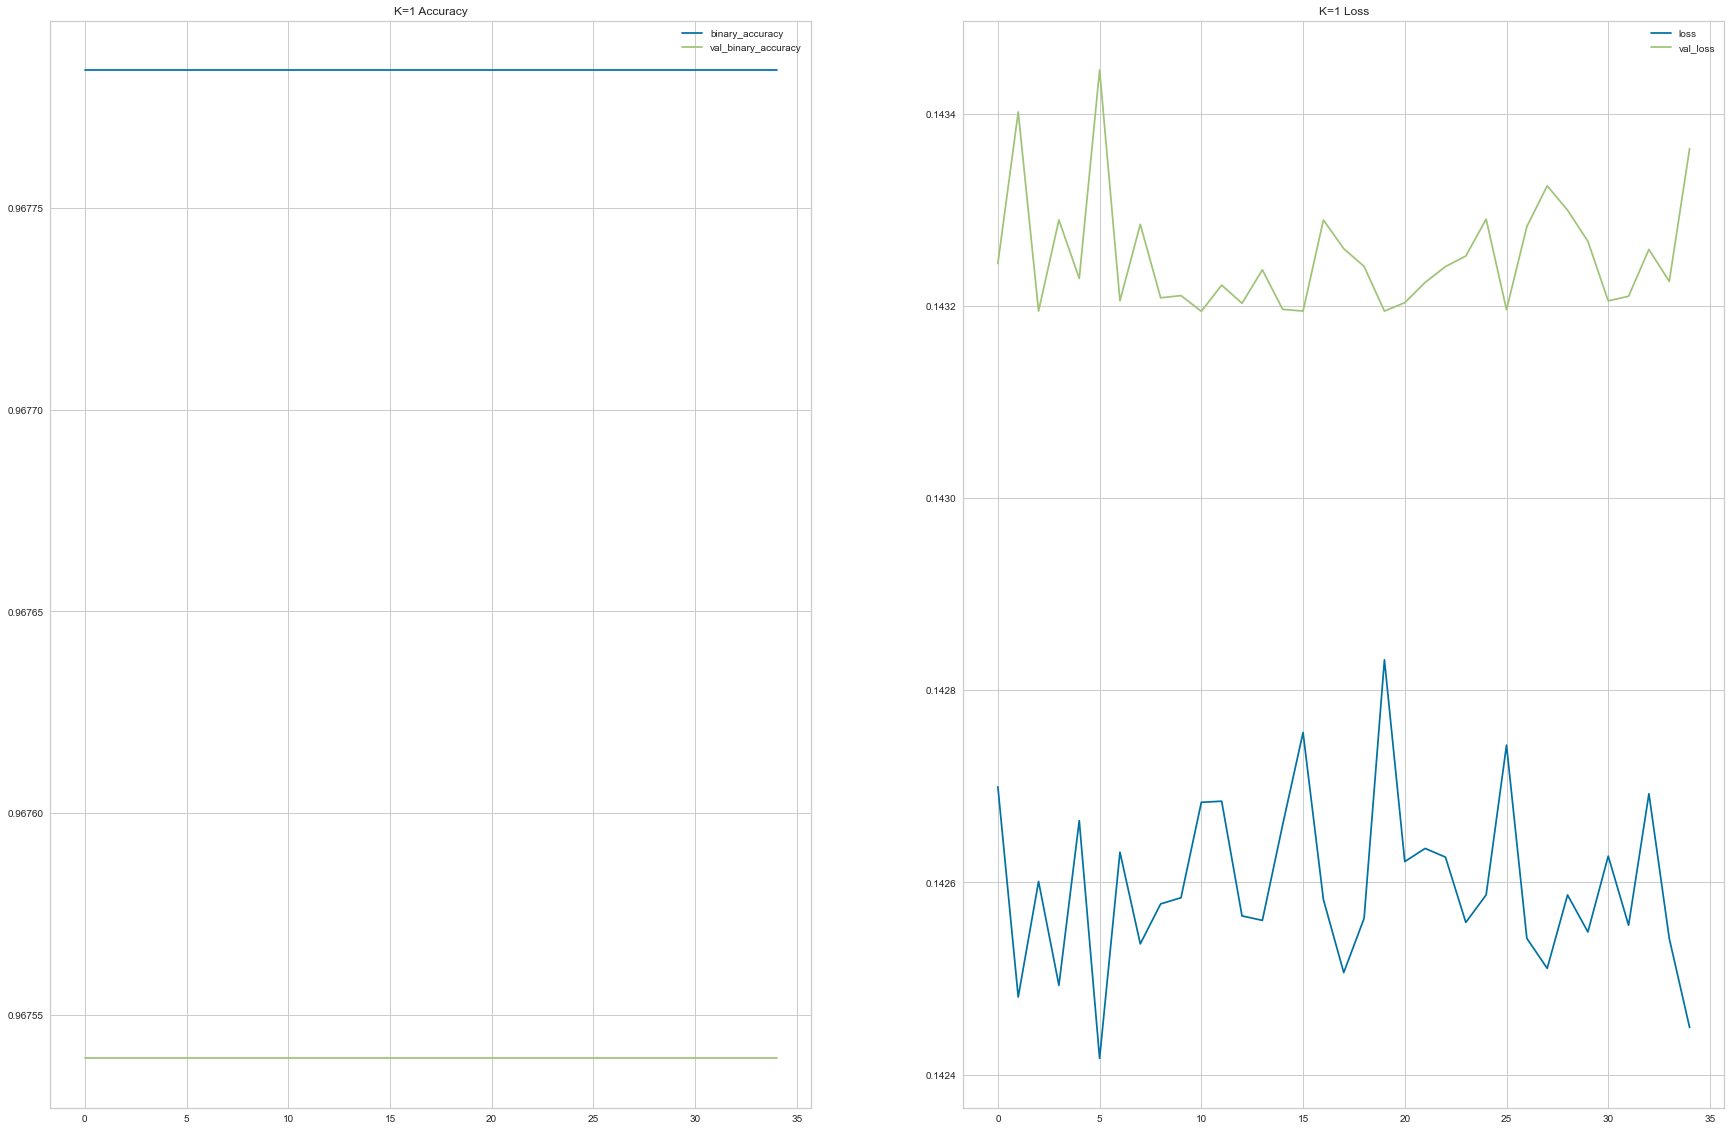

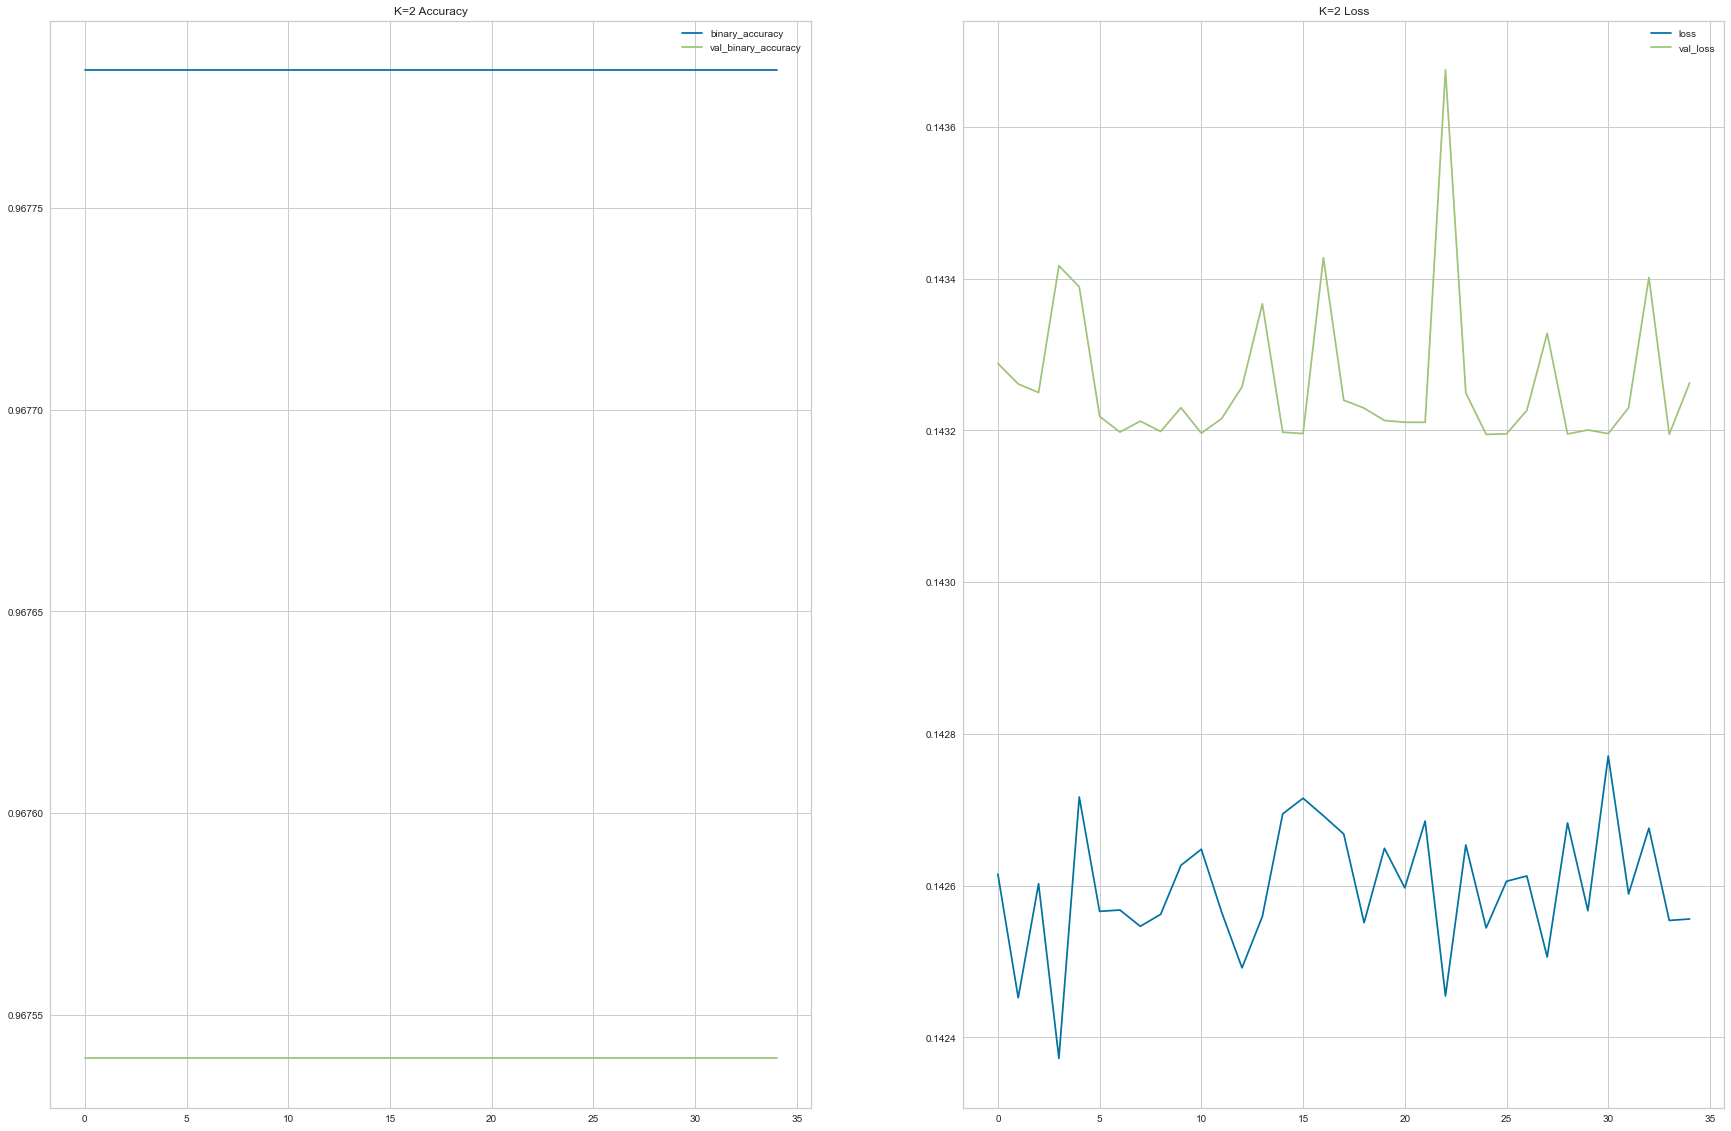

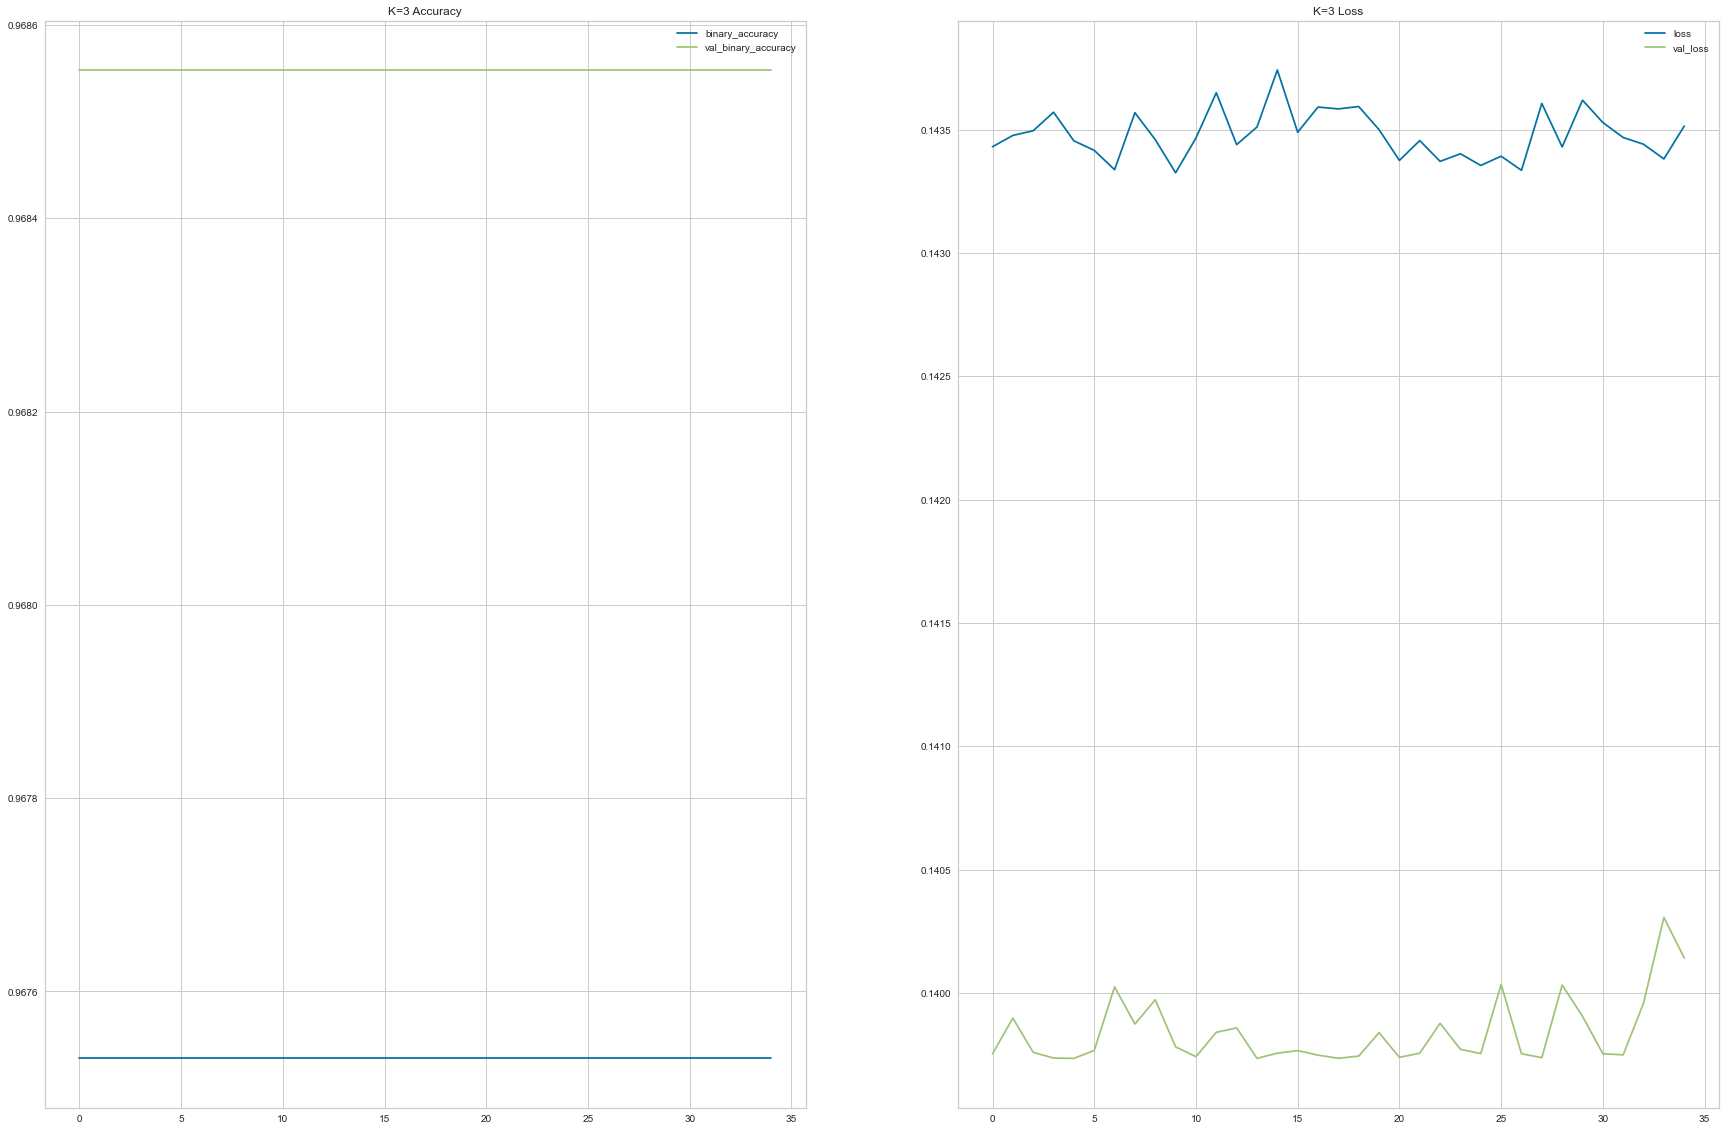

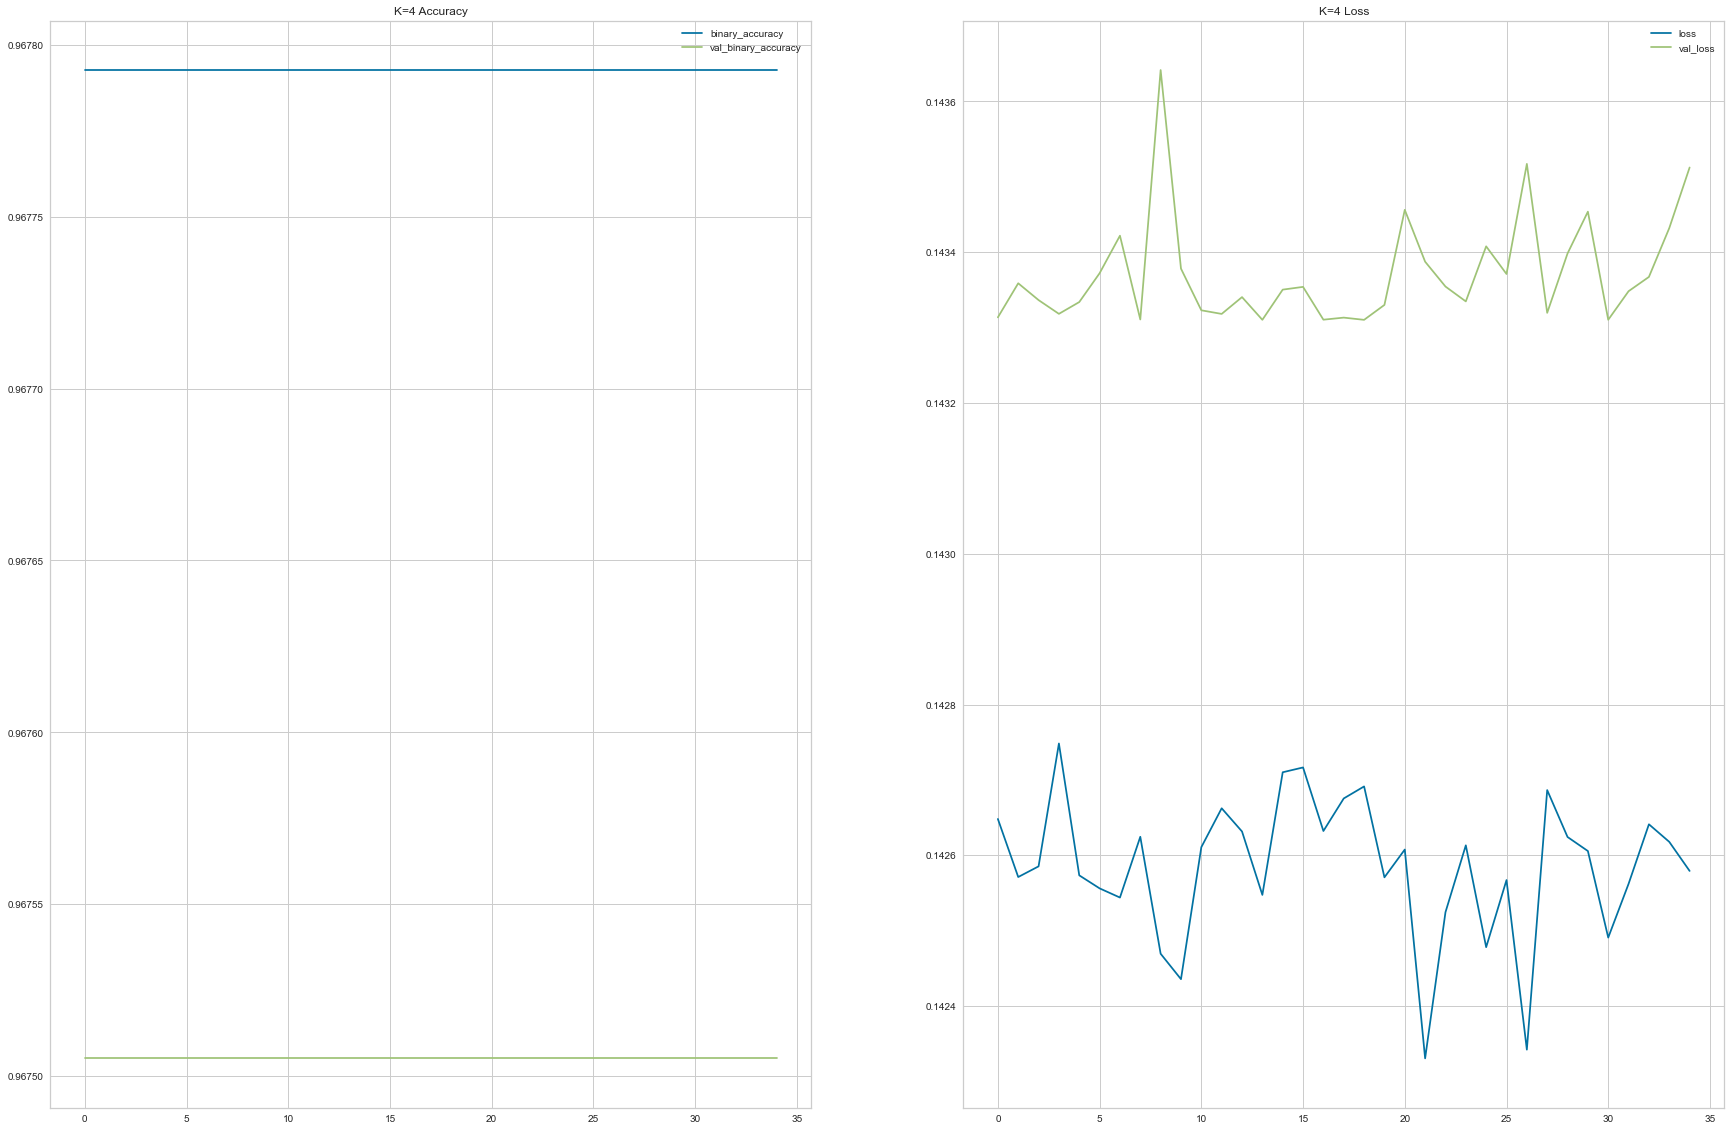

Average validation accuracy is 0.9677352905273438
Epoch 1/35
299/299 [==============================] - 2s 6ms/step - loss: 0.1091 - binary_accuracy: 0.9667
Epoch 2/35
299/299 [==============================] - 1s 5ms/step - loss: 0.0861 - binary_accuracy: 0.9682
Epoch 3/35
299/299 [==============================] - 2s 5ms/step - loss: 0.0788 - binary_accuracy: 0.9711
Epoch 4/35
299/299 [==============================] - 2s 5ms/step - loss: 0.0714 - binary_accuracy: 0.9738
Epoch 5/35
299/299 [==============================] - 1s 5ms/step - loss: 0.0666 - binary_accuracy: 0.9738
Epoch 6/35
299/299 [==============================] - 2s 6ms/step - loss: 0.0603 - binary_accuracy: 0.9776
Epoch 7/35
299/299 [==============================] - 2s 5ms/step - loss: 0.0583 - binary_accuracy: 0.9797
Epoch 8/35
299/299 [==============================] - 1s 4ms/step - loss: 0.0531 - binary_accuracy: 0.9816
Epoch 9/35
299/299 [==============================] - 2s 5ms/step - loss: 0.0485 - binary_accu

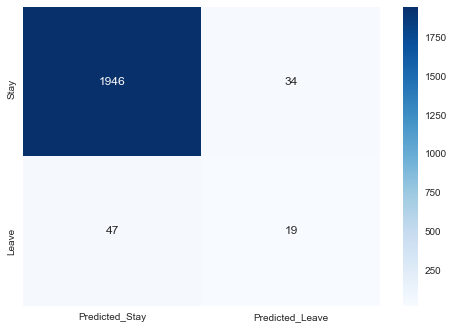

In [55]:
simple_model = create_model()
epochs = 35
batch_size = 16
simple_model_hist = kfold_val(simple_model, epochs, batch_size)
# Train model with all data
simple_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0)

              precision    recall  f1-score   support

        Stay       0.98      0.98      0.98      1980
       Leave       0.36      0.29      0.32        66

    accuracy                           0.96      2046
   macro avg       0.67      0.64      0.65      2046
weighted avg       0.96      0.96      0.96      2046



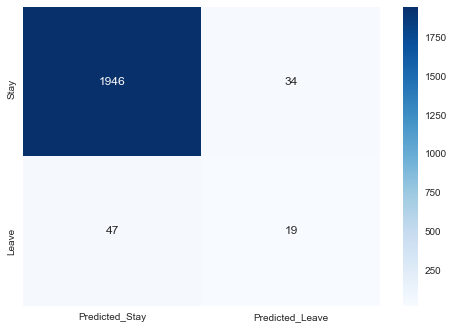

In [57]:
model_perf(simple_model)

### Class Weights
The dataset is unbalanced, most companies didn't default. One way to make sure the model is not biased toward the dominant class is assign class weight during training.

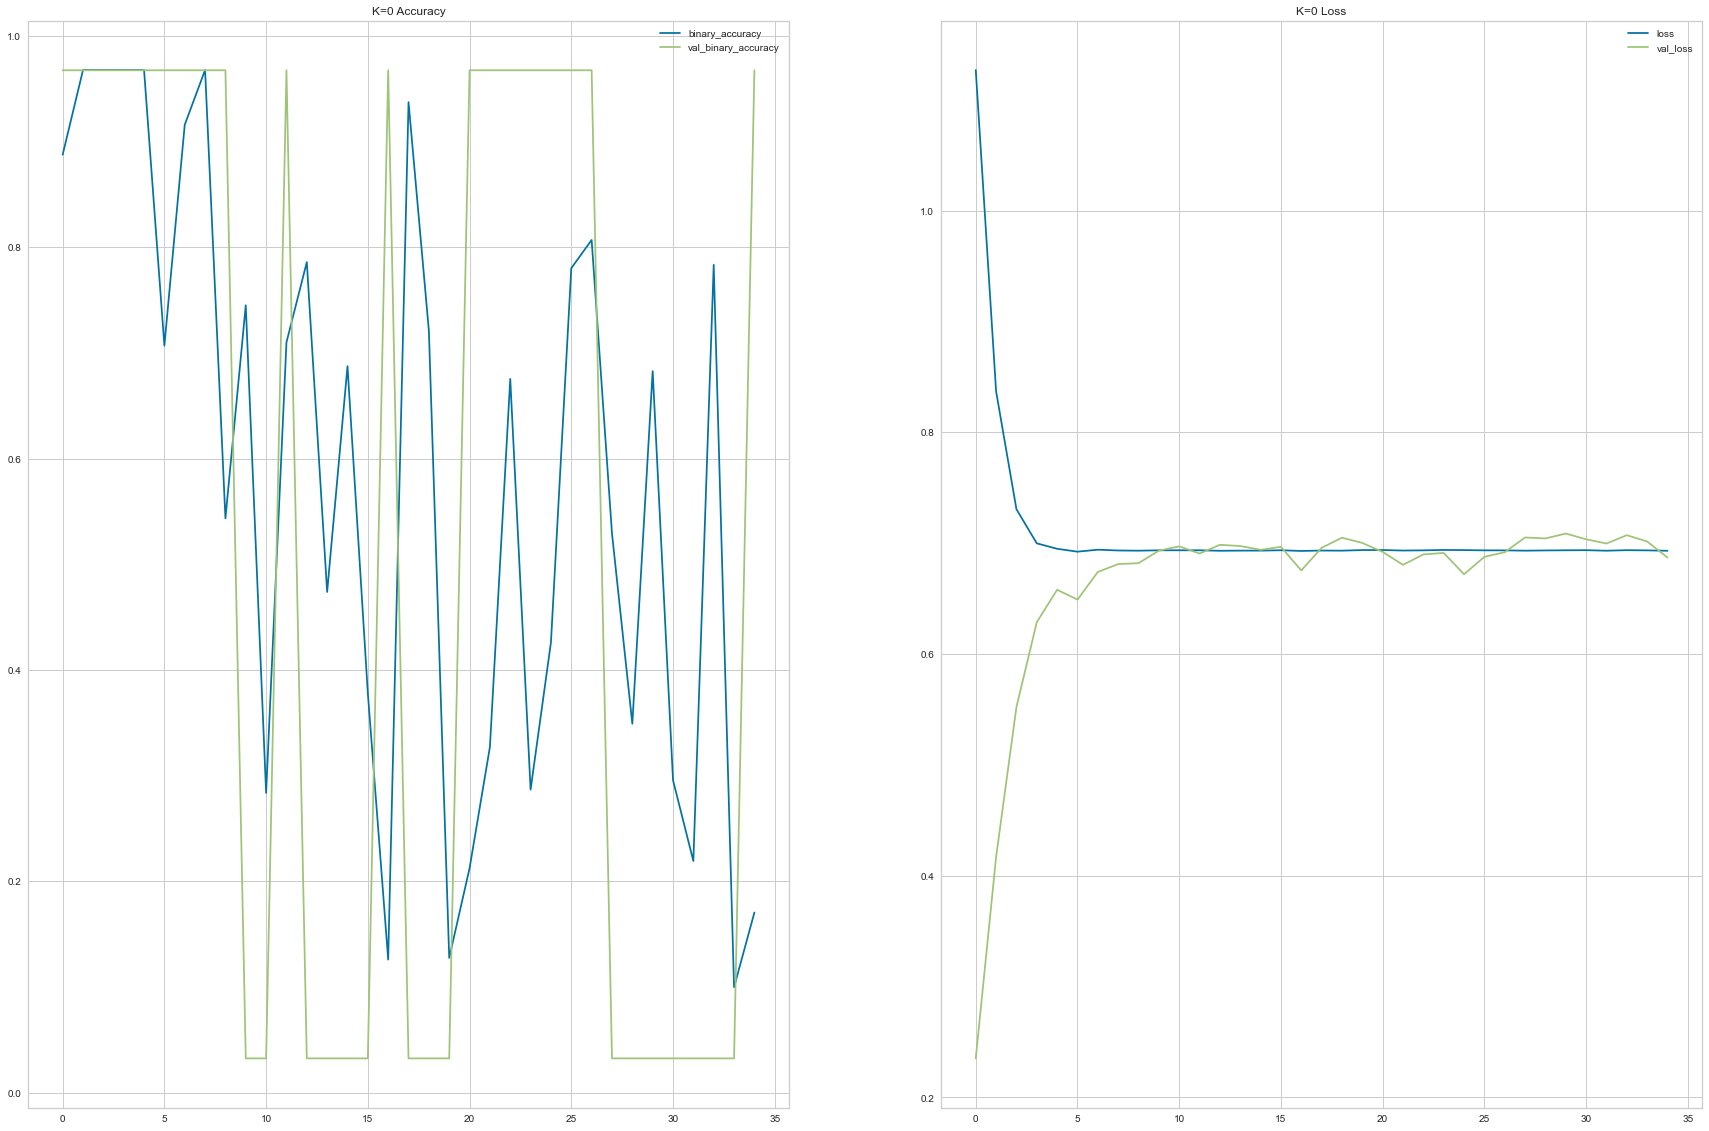

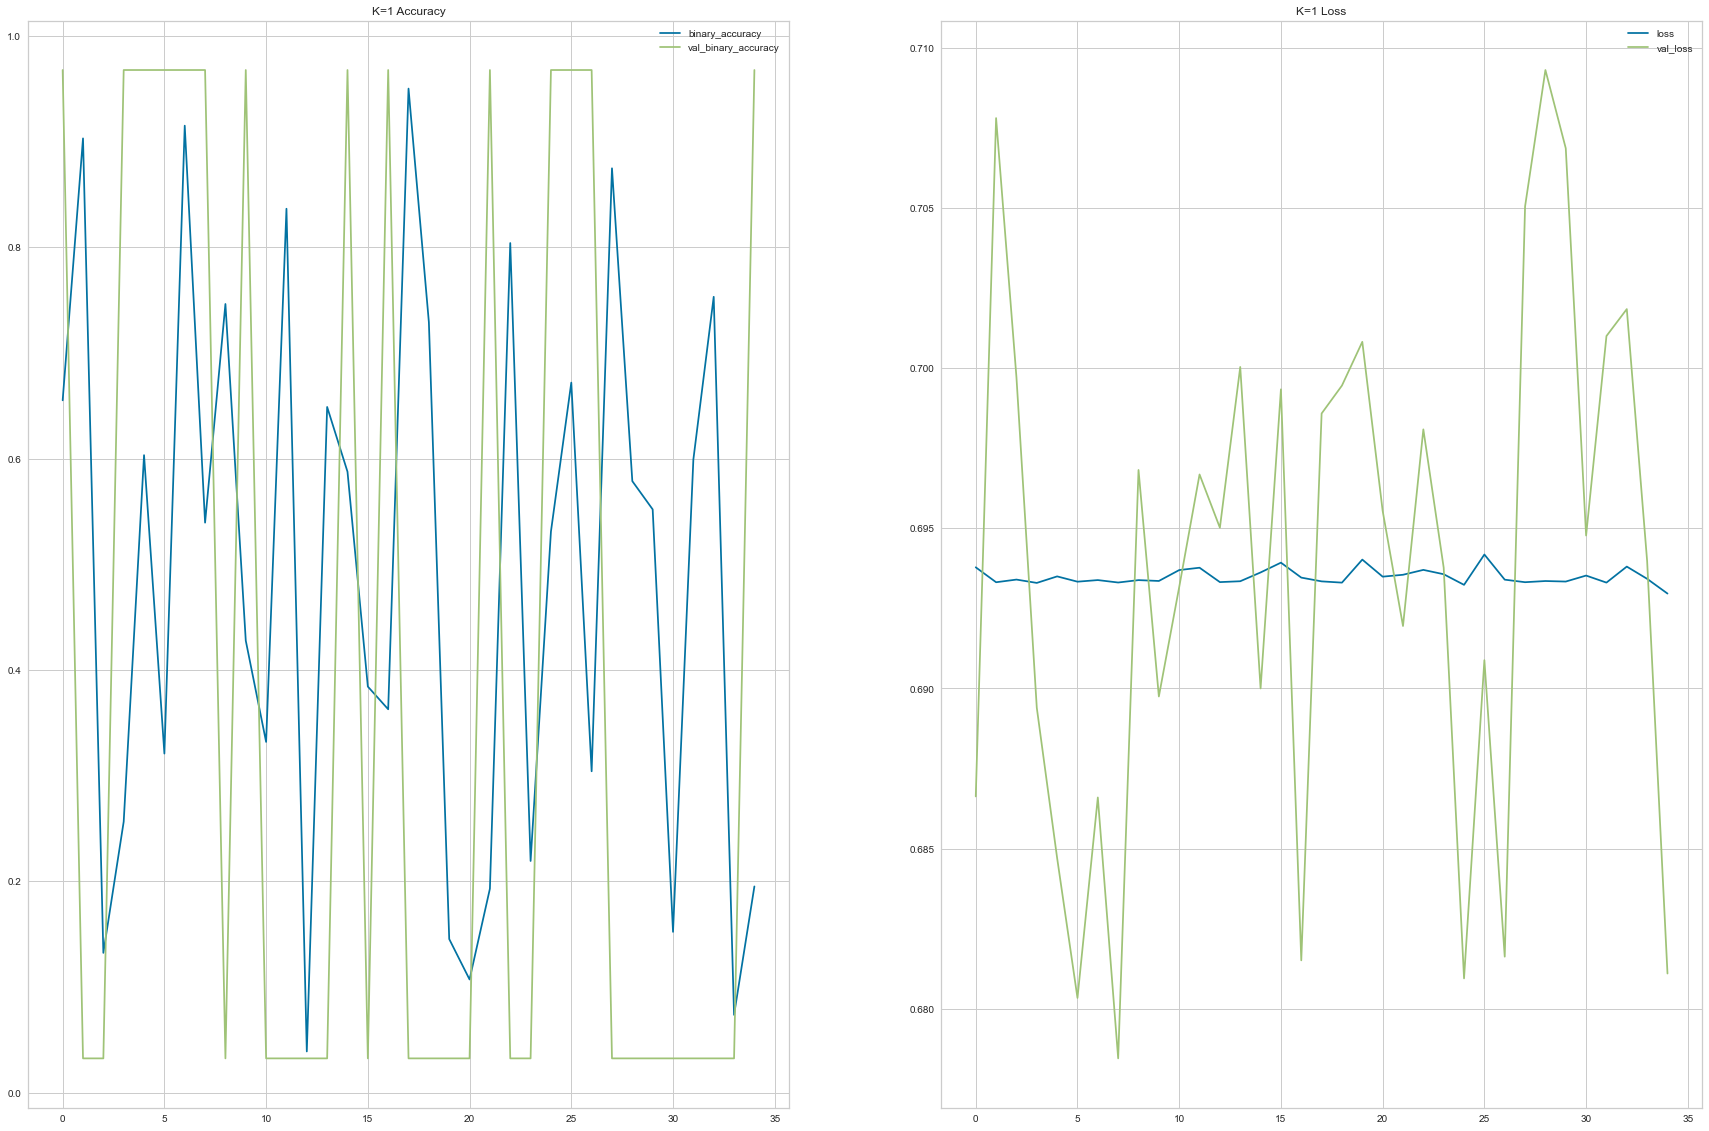

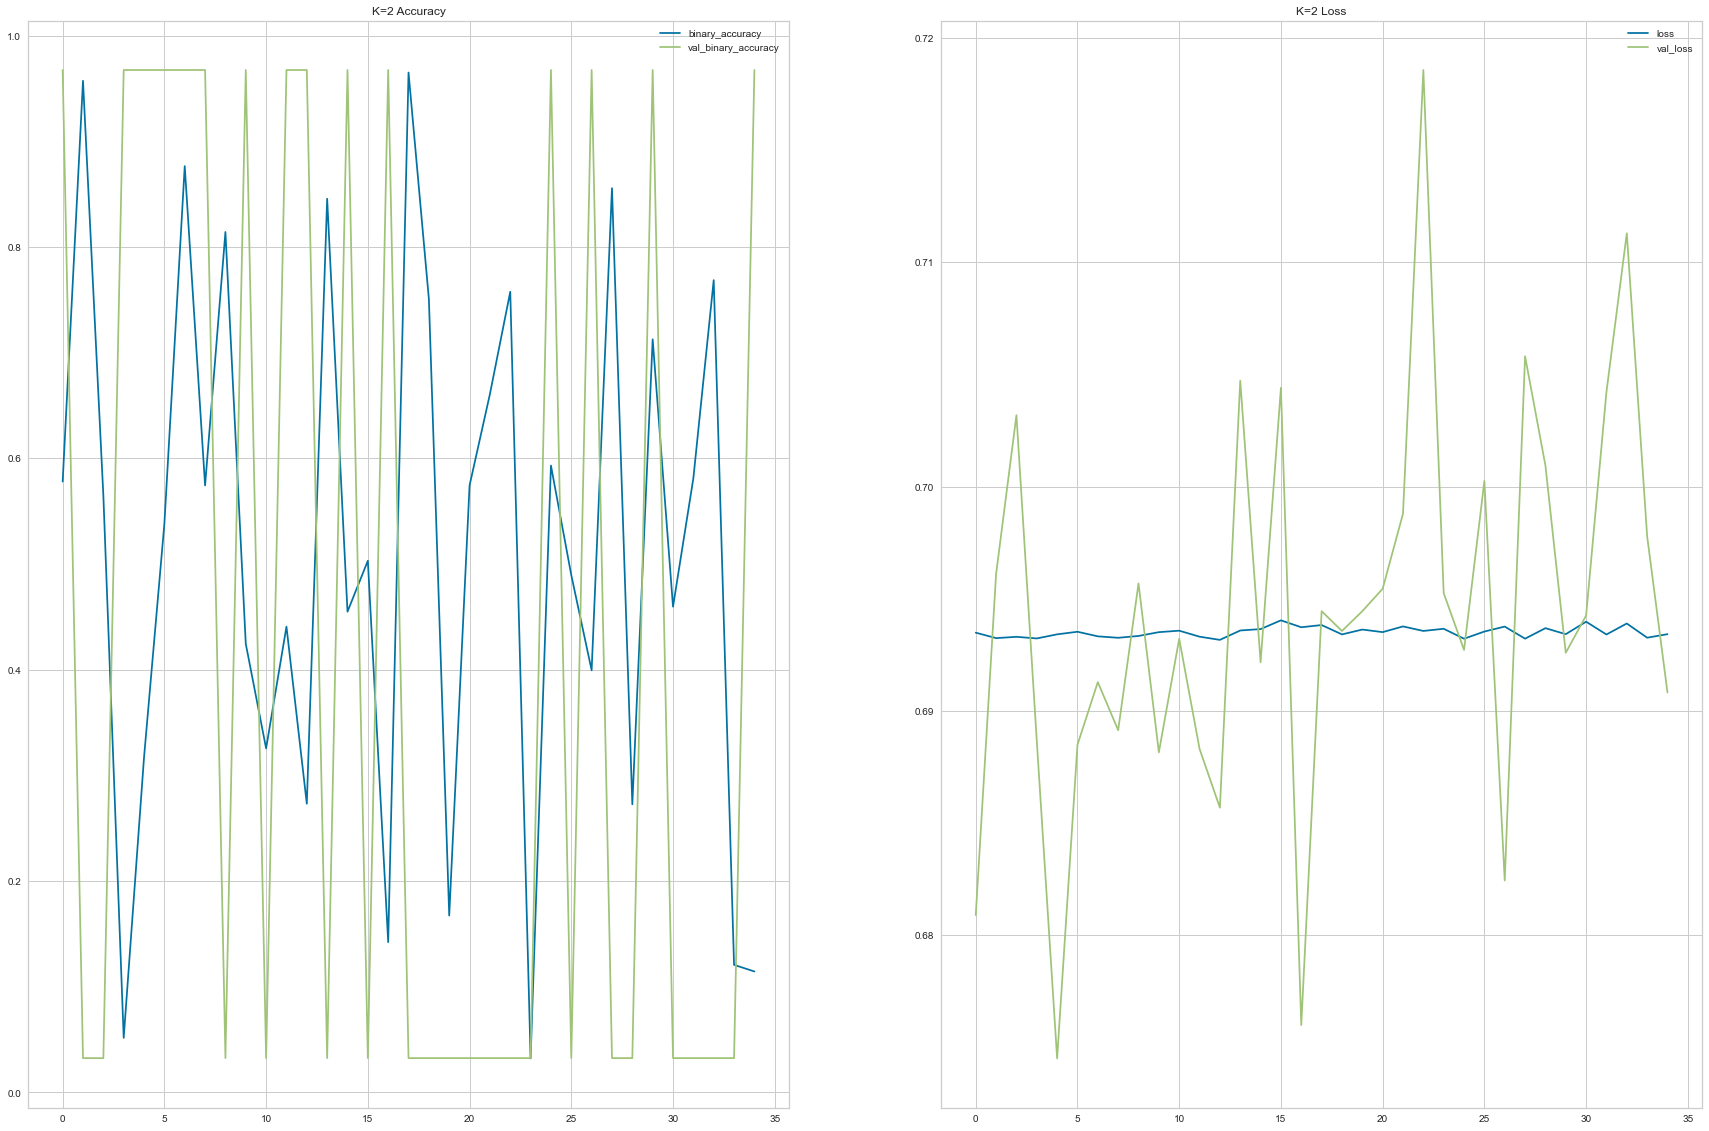

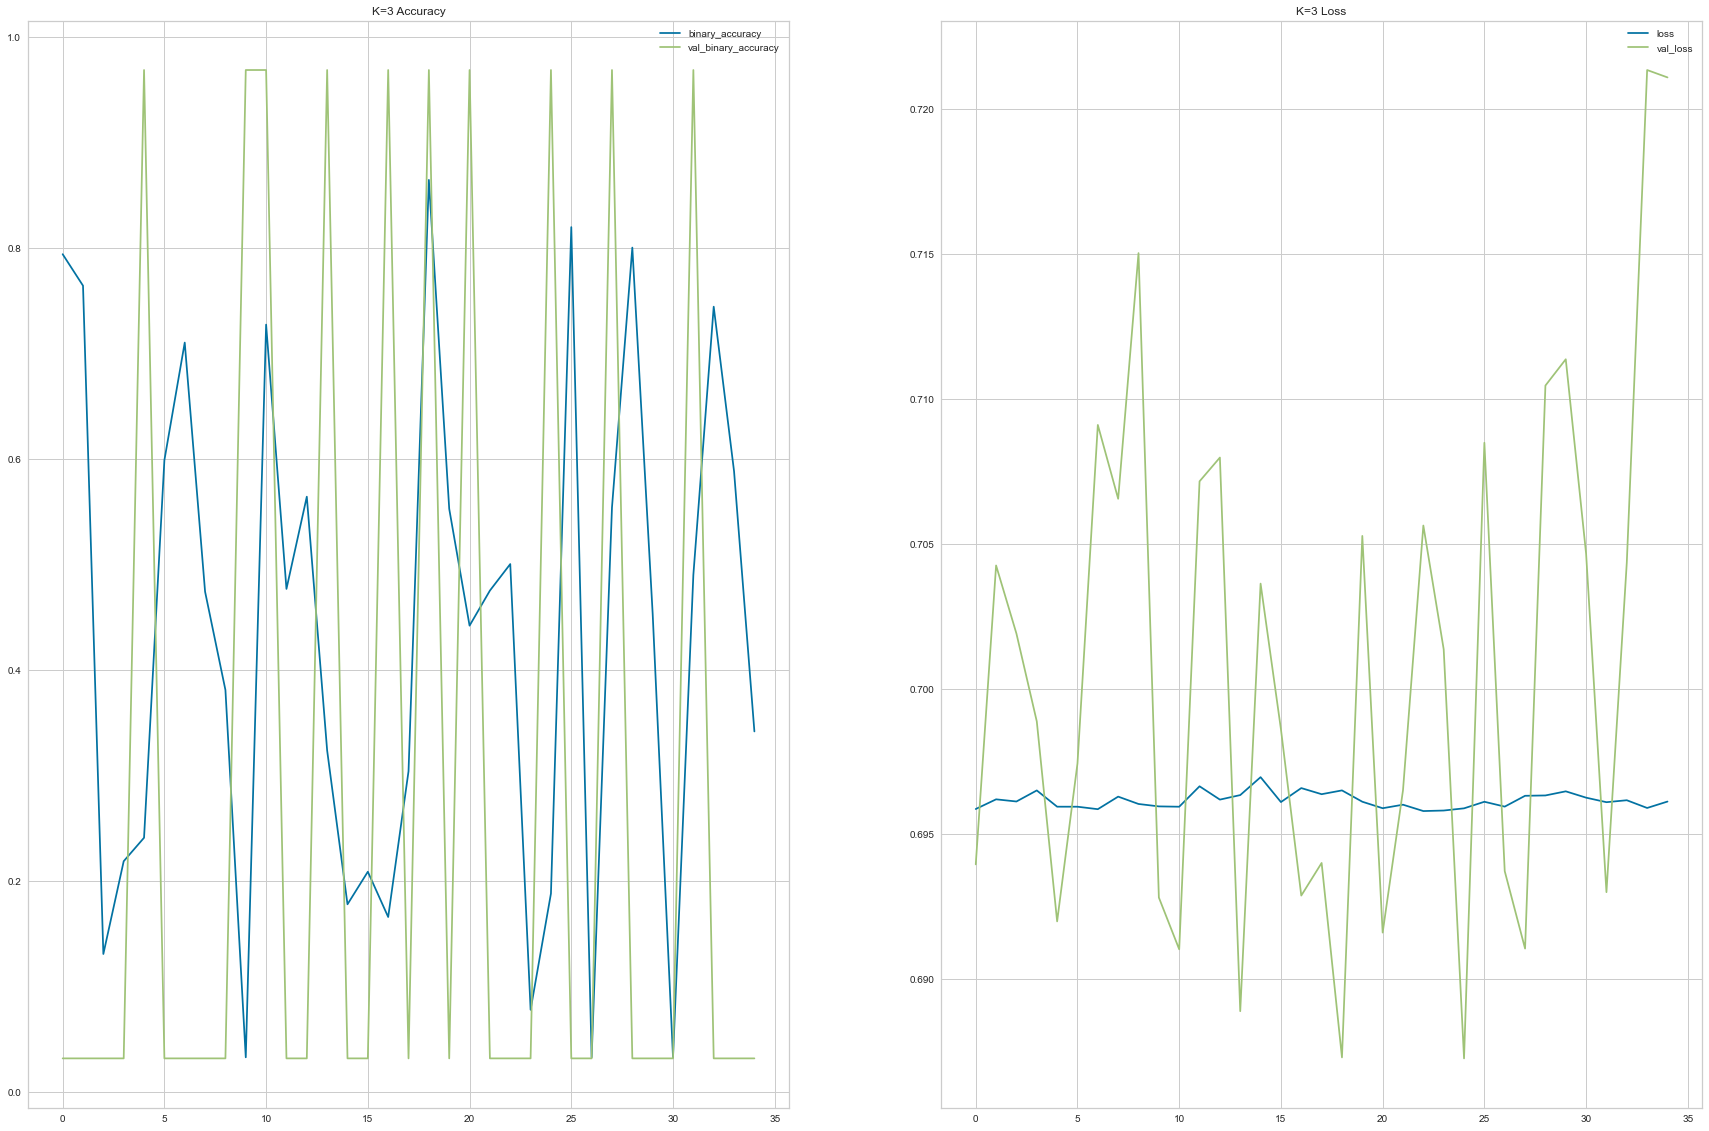

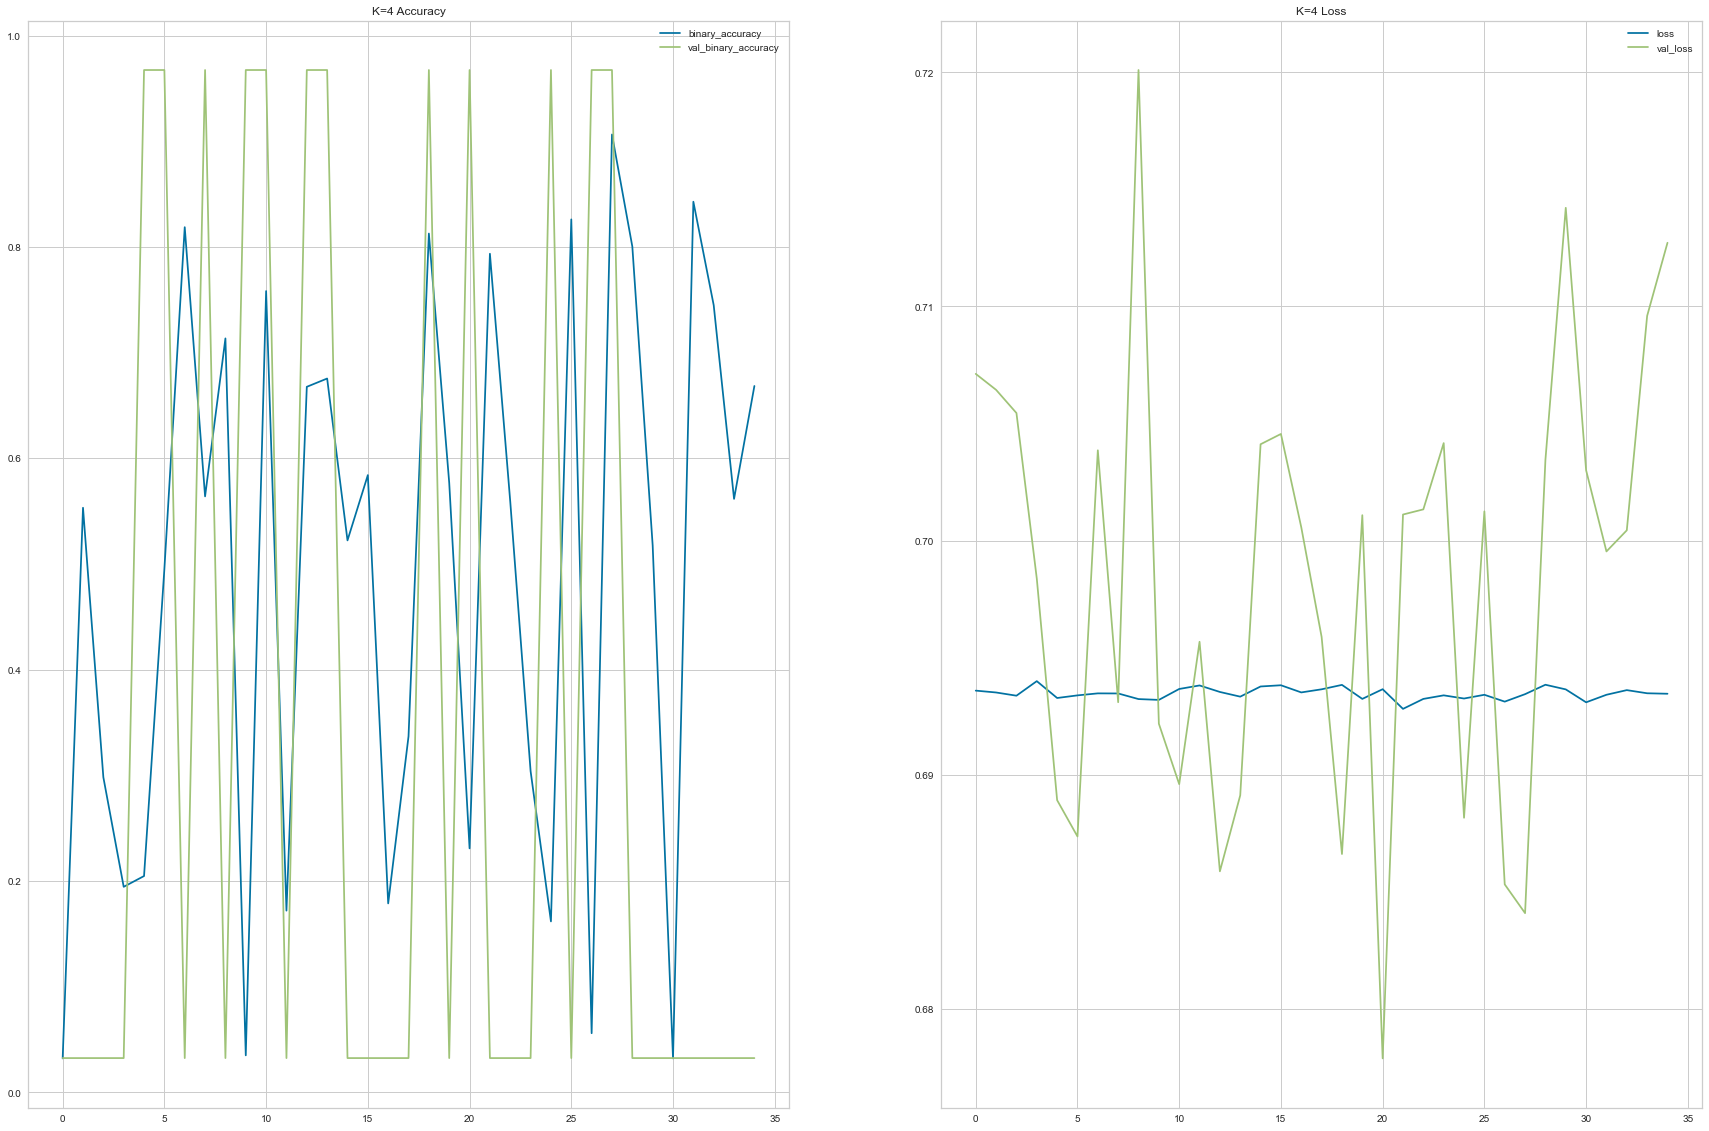

Average validation accuracy is 0.5933118104934693
Epoch 1/35
299/299 [==============================] - 2s 6ms/step - loss: 0.3201 - binary_accuracy: 0.9279
Epoch 2/35
299/299 [==============================] - 1s 4ms/step - loss: 0.1566 - binary_accuracy: 0.9677
Epoch 3/35
299/299 [==============================] - 2s 8ms/step - loss: 0.1460 - binary_accuracy: 0.9677
Epoch 4/35
299/299 [==============================] - 2s 8ms/step - loss: 0.1435 - binary_accuracy: 0.9677
Epoch 5/35
299/299 [==============================] - 2s 8ms/step - loss: 0.1428 - binary_accuracy: 0.9677
Epoch 6/35
299/299 [==============================] - 2s 6ms/step - loss: 0.1427 - binary_accuracy: 0.9677
Epoch 7/35
299/299 [==============================] - 2s 5ms/step - loss: 0.1426 - binary_accuracy: 0.9677
Epoch 8/35
299/299 [==============================] - 1s 4ms/step - loss: 0.1426 - binary_accuracy: 0.9677
Epoch 9/35
299/299 [==============================] - 1s 3ms/step - loss: 0.1426 - binary_accu

In [56]:
class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
class_weight_model = create_model()
epochs = 35
batch_size = 16
class_weight_model_hist = kfold_val(class_weight_model, epochs, batch_size, class_weight=class_weights)
# Train model with all data
class_weight_model .fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0)

              precision    recall  f1-score   support

        Stay       0.97      1.00      0.98      1980
       Leave       0.00      0.00      0.00        66

    accuracy                           0.97      2046
   macro avg       0.48      0.50      0.49      2046
weighted avg       0.94      0.97      0.95      2046



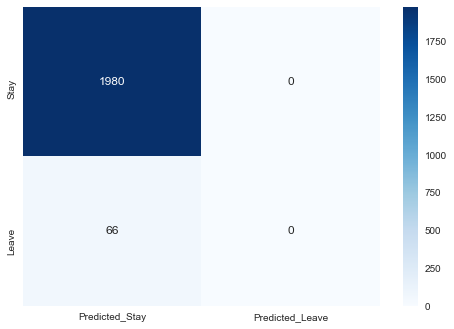

In [58]:
model_perf(class_weight_model)

## First Model:

In [45]:
# Building the first model

def create_model(nn=16, nl=1, learning_rate=0.001, activation="relu", optim="adam", 
                 init="glorot_uniform"):
    classifier = Sequential()
    # Let's add the first hidden layers
    classifier.add(Dense(units=nn, kernel_initializer=init, activation=activation,
                         input_dim=X_train.shape[1])) 
    # input_shape?
    for _ in range(nl):
        classifier.add(Dense(units=8, kernel_initializer=init, activation=activation))
        classifier.add(Dense(units=4, kernel_initializer=init, activation=activation))
        classifier.add(Dense(units=1, kernel_initializer=init, activation="sigmoid"))
    
    classifier.compile(optimizer=optim, loss="binary_crossentropy", metrics=["accuracy"])
    return classifier

### Hyper parameters tuning Using Keras tuner

In [88]:
def get_model_design_hp(hp):
    model = Sequential([Conv2D(hp.Int('filters_0',16,32,step=8,default=32),kernel_size=(5,5),padding='same',kernel_regularizer=l2(0.001),activation='relu',input_shape=INPUT_SHAPE),
                        Conv2D(hp.Int('filters_1',16,32,step=8,default=16),kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),activation='relu'),
                        MaxPool2D(pool_size=(2,2)),
                        BatchNormalization(),
                        Flatten(),
                        Dropout(hp.Float('dropout',0,0.5,step=0.25,default=0.5)),
                        Dense(units = hp.Int('Dense',32,64,step=8,default=64),activation='relu'),
                        Dropout(0.2),
                        Dense(1, kernel_initializer=GlorotNormal(), activation='sigmoid')
                       ])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss='binary_crossentropy',metrics= METRICS) 
    
    return model

In [ ]:
import kerastuner as kt

tuner = kt.Hyperband(
    get_model_design_hp,
    objective= 'val_loss' ,#'val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory = LOG_DIR    
)

In [ ]:
tuner.search(train_generator,
             validation_data = validation_generator,
             epochs=2,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [ ]:
best_model = tuner.get_best_models(1)[0]

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

In [ ]:
# How can i use this?

keras_classifier = KerasClassifier(build_fn=create_model, epochs=50, batch_size=256, verbose=1)

In [ ]:
# create model
# evaluate using 10-fold cross validation

#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
#results = cross_val_score(keras_classifier, X_train, y_train, cv=kfold)
#print(results.mean())
#print(results.std())

In [ ]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]

param_grid = dict(optim=optimizers, epochs=epochs, batch_size=batches, init=init)

random_search = RandomizedSearchCV(estimator=keras_classifier, param_distributions=param_grid)

random_search_results = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))
means = random_search_results.cv_results_['mean_test_score']
stds = random_search_results.cv_results_['std_test_score']
params = random_search_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Print results
print("Best: %f using %s".format(random_search_results.best_score_, random_search_results.best_params_))

In [ ]:
classifier = create_model(nn=16)

In [ ]:
classifier.summary()

In [ ]:
# Path + name of the file we wanna create.
path_checkpoint = "model_checkpoint.h5"

early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="auto")

model_save = ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, 
                             save_best_only=True)

Hist = History()

In [61]:
class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
class_weights

{0: 0.5166942931565238, 1: 15.47517730496454}

In [ ]:
hist = classifier.fit(X_train, y_train,  
                      batch_size=64,
                      validation_split=0.2,
                      epochs=1000,
                      callbacks = [early_stopping, model_save, Hist],  
                      #class_weight=class_weights
                     )

In [ ]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
y_pred_train=(y_pred_train>0.5).astype(int)
y_pred_test=(y_pred_test>0.5).astype(int)

In [ ]:
# Show the confusion matrix
cm = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
print('Classification Report')

target_names=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, 
                                 y_test, y_pred_test)
resultsDF

In [ ]:
visualize_loss(hist, "Training and validation loss")

In [ ]:
visualize_accuracy(hist, "Training and validation accuracy")

## Using class_weight:

## Using a Focal Loss:

https://github.com/umbertogriffo/focal-loss-keras

In [ ]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## Using S.M.O.T.E:

In [ ]:
# S.M.O.T.E

sm = SMOTE(k_neighbors=10, random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

- This part is inspired from:
https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

An LSTM is a neural network, which sequentially loops after each observation. This means that the observations are equipped with a forgetting structure, similar to exponential smoothing. 

We have to reshape the dataset into the structure [samples, timesteps, features].

In [ ]:
t2 = time.perf_counter()
print('time taken to run:',(t2-t1)/60.0)